# 文生图-Dreambooth

同济子豪兄 2023-6-13

https://github.com/open-mmlab/mmagic/tree/main/configs

## 进入 MMagic 主目录

In [2]:
import os
os.chdir('mmagic')

## 在数据集上训练Dreambooth

In [4]:
# !bash tools/dist_train.sh configs/dreambooth/dreambooth.py 1

!bash tools/dist_train.sh configs/dreambooth/dreambooth-lora.py 1

/environment/miniconda3/lib/python3.8/site-packages/torch/distributed/launch.py:178: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
/environment/miniconda3/lib/python3.8/site-packages/mmengine/utils/dl_utils/setup_env.py:46: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
/environment/miniconda3/lib/python3.8/site-packages/mmengine/utils/dl_utils/setup_env.py:56: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in defaul

## 用训练好的模型做预测

In [3]:
from mmengine import Config

from mmagic.registry import MODELS
from mmagic.utils import register_all_modules

register_all_modules()

In [9]:
cfg = Config.fromfile('./mmagic/configs/dreambooth/dreambooth-lora.py')

In [10]:
dreambooth_lora = MODELS.build(cfg.model)

06/13 20:16:34 - mmengine - INFO - Set model dtype to 'torch.float16'.
06/13 20:16:38 - mmengine - INFO - Creating runwayml/stable-diffusion-v1-5 by 'HuggingFace'
Do not support Xformers. Please install Xformers first. The program will run without Xformers.
06/13 20:16:38 - mmengine - INFO - Set VAE untrainable.
06/13 20:16:38 - mmengine - INFO - Move VAE to torch.float16.
06/13 20:16:38 - mmengine - INFO - Set Text Encoder untrainable.
06/13 20:16:38 - mmengine - INFO - Move Text Encoder to torch.float16.
06/13 20:16:38 - mmengine - INFO - Set Unet untrainable.
06/13 20:16:38 - mmengine - INFO - Set LoRA for 'model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q' with suffix match 'to_q'.
06/13 20:16:38 - mmengine - INFO - Set LoRA for 'model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k' with suffix match 'to_k'.
06/13 20:16:38 - mmengine - INFO - Set LoRA for 'model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v' with suffix match 'to_v'.
06/13 20

In [19]:
state = torch.load('mmagic/work_dirs/dreambooth-lora/iter_1000.pth')['state_dict']

In [48]:
def convert_state_dict(state):
    state_dict_new = {}
    for k, v in state.items():
        if '.module' in k:
            k_new = k.replace('.module', '')
        else:
            k_new = k
        if 'vae' in k:
            if 'to_q' in k:
                k_new = k.replace('to_q', 'query')
            elif 'to_k' in k:
                k_new = k.replace('to_k', 'key')
            elif 'to_v' in k:
                k_new = k.replace('to_v', 'value')
            elif 'to_out' in k:
                k_new = k.replace('to_out.0', 'proj_attn')
        state_dict_new[k_new] = v
    return state_dict_new

In [49]:
dreambooth_lora.load_state_dict(convert_state_dict(state))
dreambooth_lora = dreambooth_lora.cuda()

In [57]:
samples = dreambooth_lora.infer('side view of sks dog', guidance_scale=5)

  0%|          | 0/50 [00:00<?, ?it/s]

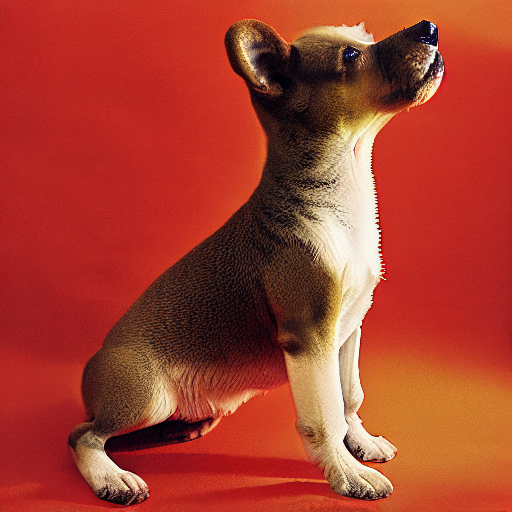

In [58]:
samples['samples'][0]

In [59]:
samples = dreambooth_lora.infer('ear close-up of sks dog', guidance_scale=5)

  0%|          | 0/50 [00:00<?, ?it/s]

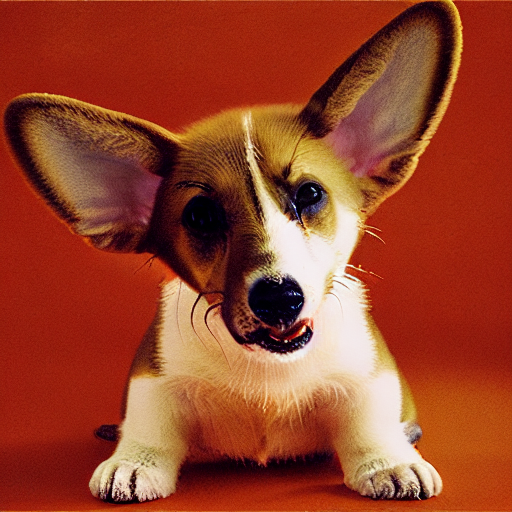

In [60]:
samples['samples'][0]